In [2]:
# Baixar arquivos adicionais para o laboratório
!wget https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
      
!unzip -n -q lab_utils_ml_adv_week_1.zip

--2024-03-10 13:55:12--  https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip [following]
--2024-03-10 13:55:13--  https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1984922 (1.9M) [application/zip]
Saving to: ‘l

In [3]:
# Testar se estamos no Google Colab
try:
  import google.colab
  IN_COLAB = True
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  IN_COLAB = False

# Rede Neural Simples com Numpy
Neste laboratório, criaremos uma pequena rede neural usando o Numpy. Será a mesma rede de "torrefação de café" que você implementou no Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from lab_utils_common import dlc, sigmoid
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2024-03-10 13:55:17.053506: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 13:55:17.076428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 13:55:17.076453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 13:55:17.076468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 13:55:17.080934: I tensorflow/core/platform/cpu_feature_g

## Conjunto de Dados
Este é o mesmo conjunto de dados do laboratório anterior.

In [5]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Vamos plotar os dados de torrefação de café abaixo. Os dois recursos são Temperatura em Celsius e Duração em minutos. A [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) sugere que a duração deve ser mantida entre 12 e 15 minutos, enquanto a temperatura deve estar entre 175 e 260 graus Celsius. É claro que, à medida que a temperatura aumenta, a duração deve diminuir.

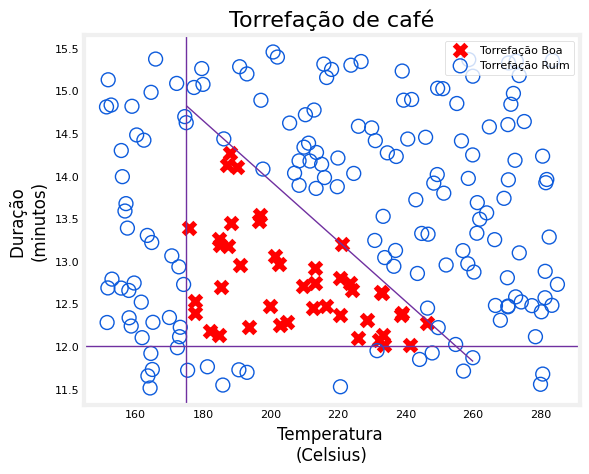

In [6]:
plt_roast(X,Y)

### Normalizar dados
Para corresponder ao laboratório anterior, normalizaremos os dados. Consulte o laboratório anterior para obter mais detalhes

In [7]:
print(f"Temperature Máxima, Min antes da normalização: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min antes da normalização: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min após a normalização: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min após a normalização: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Máxima, Min antes da normalização: 284.99, 151.32
Duration    Max, Min antes da normalização: 15.45, 11.51


2024-03-10 13:57:58.617808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 13:57:58.621303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 13:57:58.621454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Temperature Max, Min após a normalização: 1.66, -1.69
Duration    Max, Min após a normalização: 1.79, -1.70


## Modelo Numpy - Propagação direta(_Forward Propagation_) no NumPy
<center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Vamos criar a "Rede de torrefação de café" descrita na aula. Há duas camadas com ativações sigmoides.

Conforme descrito na aula, é possível criar sua própria camada densa usando o NumPy. Isso pode ser utilizado para criar uma rede neural de várias camadas.

<img src="images/C2_W1_dense3.png" width="600" height="450">

No primeiro laboratório você construiu um neurônio no NumPy e no Tensorflow e observou a semelhança entre eles. Uma camada simplesmente contém vários neurônios/unidades. Conforme descrito na aula, é possível utilizar um loop for para visitar cada unidade (`j`) na camada e executar o produto escalar dos pesos dessa unidade (`W[:,j]`) e somar o viés  da unidade (`b[j]`) para formar `z`. Uma função de ativação `g(z)` pode então ser aplicada a esse resultado. Vamos tentar isso abaixo para criar uma sub-rotina de "camada densa".

Primeiro, você definirá a função de ativação `g()`. Você usará a função `sigmoid()` que já está implementada para você no arquivo `lab_utils_common.py` fora deste notebook.

In [8]:
# Definir a função de ativação
g = sigmoid

Em seguida, você definirá a função `my_dense()` que calcula as ativações de uma camada densa.

In [9]:
def my_dense(a_in, W, b):
    """
    Calcula a camada densa
    Args:
      a_in (ndarray (n, )) : Dados, 1 exemplo
      W    (ndarray (n,j)) : Matriz de peso, n recursos por unidade, j unidades
      b    (ndarray (j, )) : vetor de bias, j unidades
    Returns
      a_out (ndarray (j,))  : j unidades|
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j]                                    
        z = np.dot(w, a_in) + b[j]         
        a_out[j] = g(z)               
    return(a_out)

*Observação: você também pode implementar a função acima para aceitar `g` como um parâmetro adicional (por exemplo, `my_dense(a_in, W, b, g)`). No entanto, neste notebook, você usará apenas um tipo de função de ativação (ou seja, sigmoide), portanto, não há problema em torná-la constante e defini-la fora da função. Foi o que você fez no código acima e isso simplifica as chamadas de função nas próximas células de código. Lembre-se de que passá-lo como um parâmetro também é uma implementação aceitável. Você verá isso na tarefa desta semana.*

The following cell builds a two-layer neural network utilizing the `my_dense` subroutine above.

In [8]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1)
    a2 = my_dense(a1, W2, b2)
    return(a2)

We can copy trained weights and biases from the previous lab in Tensorflow.

In [9]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by writing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ examples in the rows and make a prediction by running the model.

In [10]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
    return(p)

We can try this routine on two examples:

In [11]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

/tmp/ipykernel_16379/3168763570.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)


To convert the probabilities to a decision, we apply a threshold:

In [12]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [13]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Network function

This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

/tmp/ipykernel_16379/3168763570.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)


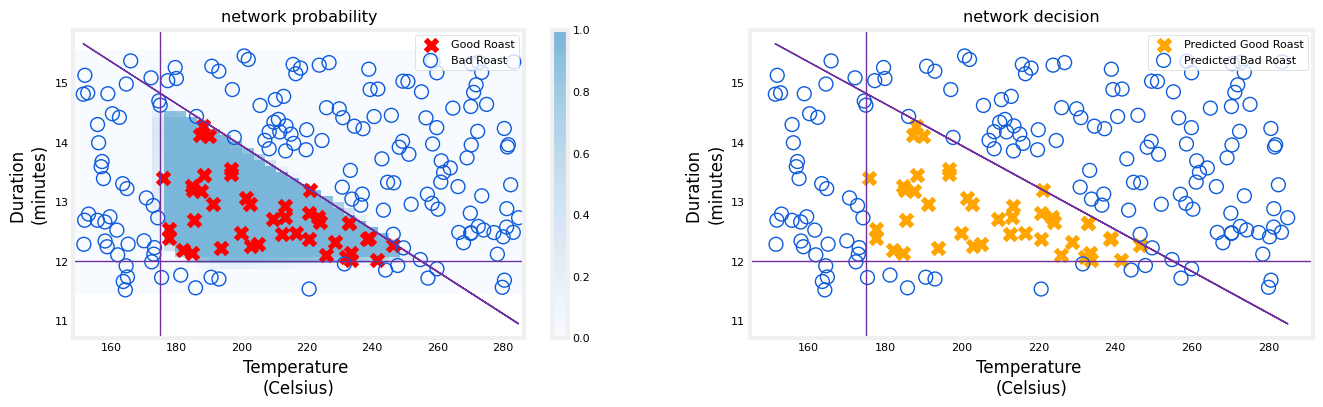

In [14]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in NumPy. 
Hopefully this lab revealed the fairly simple and familiar functions which make up a layer in a neural network. 